In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/MyDrive/Topic-Based-Image-Captioning

/content/gdrive/.shortcut-targets-by-id/1-ONgVBBRmgm-jm2cL02JKEARq6t1r463/Topic-Based-Image-Captioning


### Image Pre-processing

In [3]:
from models.inception_v3 import load_inception_v3
from dataset.utils import load_image
from tensorflow.keras import backend as K
import numpy as np

path1 = '/content/138254822_2262647467201203_817774093647937774_o.jpg'
path2 = '/content/2021-01-18 02_59_29-Window.png'

model = load_inception_v3()

img_size = K.int_shape(model.input)[1:3]  # Expected input size of the pre-trained network
img1 = load_image(path1, size=img_size, grayscale=False)
img2 = load_image(path2, size=img_size, grayscale=False)

img_feature1 = model.predict(np.array([img1]))
img_feature2 = model.predict(np.array([img2]))

### Image Topic Detector

In [4]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model
import tensorflow as tf
from keras.optimizers import Adam, SGD

test_model = Sequential()

test_model.add(Dense(3072, input_shape=(2048,), activation='tanh'))
test_model.add(Dropout(0.4))
test_model.add(Dense(1024, activation='tanh'))
test_model.add(Dropout(0.2))
test_model.add(Dense(1536, activation='tanh'))
test_model.add(Dropout(0.1))
test_model.add(Dense(3072, activation='relu'))
test_model.add(Dropout(0.1))
test_model.add(Dense(1024, activation='tanh'))
test_model.add(Dropout(0.3))
test_model.add(Dense(768, activation='tanh'))
test_model.add(Dropout(0.1))
test_model.add(Dense(80, activation='sigmoid'))

opt = SGD(lr=0.01, momentum=0.9)
test_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy())

Loading weights...

In [5]:
test_model.load_weights('/content/gdrive/MyDrive/Topic-Based-Image-Captioning/itd_coco_inceptions.hdf5')

Predicting Topics....

In [6]:
pred_topics1 = test_model.predict(img_feature1)
pred_topics2 = test_model.predict(img_feature2)

In [7]:
cd /content/gdrive/My Drive/TopicOrientedImageCaption/order-embedding

/content/gdrive/.shortcut-targets-by-id/1IJ8OMkrT_d-bYuNPFeuQ7L5wKdbvtrXo/TopicOrientedImageCaption/order-embedding


### Loading Order Embedding Model

In [8]:
import theano
from utils import load_params, init_tparams
from model import init_params, build_sentence_encoder, build_image_encoder, build_topic_encoder, build_errors
import pickle as pkl

def load_model(path_to_model, path_to_params):
    """
    Load all model components
    """
    # Load model
    print('Loading model')
    with open(path_to_model + '.pkl', 'rb') as f:
        model_options = pkl.load(f, encoding='latin1')

    options = model_options
    
    # Load parameters
    print('Loading model parameters...')
    params = init_params(options)
    params = load_params(path_to_params + '.npz', params)
    tparams = init_tparams(params)

    # Extractor functions
    print('Compiling sentence encoder...')
    [x, x_mask], sentences = build_sentence_encoder(tparams, options)
    f_senc = theano.function([x, x_mask], sentences, name='f_senc')

    print('Compiling image encoder...')
    [im], images = build_image_encoder(tparams, options)
    f_ienc = theano.function([im], images, name='f_ienc')
    
    print('Compiling topic encoder...')
    [t], topics = build_topic_encoder(tparams, options)
    f_tenc = theano.function([t], topics, name='f_tenc')

    print('Compiling error computation...')
    [s, im], errs = build_errors(options)
    f_err = theano.function([s,im], errs, name='f_err')

    # Store everything we need in a dictionary
    print('Packing up...')
    model_options['f_senc'] = f_senc
   
    model_options['f_ienc'] = f_ienc
    model_options['f_tenc'] = f_tenc
    
    model_options['f_err'] = f_err
    return model_options

In [9]:
order_model = load_model('./model_options','./oe_weights_coco')

Loading model
Loading model parameters...
Compiling sentence encoder...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compiling image encoder...
Compiling topic encoder...
Compiling error computation...
Packing up...


Creating image and topic embeddings...

In [10]:
import tools

image_embedding1 = tools.encode_images(order_model, img_feature1)
topic_embedding1 = tools.encode_topics(order_model, pred_topics1)

image_embedding2 = tools.encode_images(order_model, img_feature2)
topic_embedding2 = tools.encode_topics(order_model, pred_topics2)

In [11]:
with open('/content/gdrive/MyDrive/Topic-Based-Image-Captioning/captions_train_p2.pkl', 'rb') as f:
  trainCaptions = pkl.load(f)

In [12]:
temp = []
for cap_list in trainCaptions:
  for cap in cap_list:
    temp.append('startseq ' + cap + ' endseq')

trainCaptions = temp

In [13]:
from keras.preprocessing.text import Tokenizer

def create_tokenizer(sentences, start_end = True, use_all = False):
    num_words = None
    if use_all:
        tokenizer = Tokenizer()
    else:
        if num_words:
            tokenizer = Tokenizer(num_words)
        else:
            tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

tokenizer = create_tokenizer(trainCaptions)
n_vocabs = len(tokenizer.word_index) + 1
print('number of vocabulary: %d' % n_vocabs)

number of vocabulary: 26667


In [14]:
cd /content/gdrive/MyDrive/Topic-Based-Image-Captioning

/content/gdrive/.shortcut-targets-by-id/1-ONgVBBRmgm-jm2cL02JKEARq6t1r463/Topic-Based-Image-Captioning


In [15]:
max_len = 30

### Language Model

In [16]:
import tensorflow as tf
from keras.layers.merge import add
import keras.layers as layers
from keras.layers.merge import concatenate
from models.embeddings import create_embedding_layer

from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate,Reshape,BatchNormalization, Lambda
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg19 import VGG19, preprocess_input

import numpy as np
import h5py
import string
import pickle

from os import listdir
from os.path import join, isdir, isfile, exists

glove_file = './glove.6B.300d.txt'

class WeightedSum(layers.Layer):
    """A custom keras layer to learn a weighted sum of tensors"""

    def __init__(self, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)

    def build(self, input_shape=1):
        self.a = self.add_weight(
            name='alpha',
            shape=(1024,),
            initializer=tf.keras.initializers.Constant(0.5),
            constraint = tf.keras.constraints.min_max_norm(max_value=1,min_value=0),
            dtype='float32',
            trainable=True,
        )
        super(WeightedSum, self).build(input_shape)

    def call(self, model_outputs):
        return self.a * model_outputs[0] + (1 - self.a) * model_outputs[1]

    def compute_output_shape(self, input_shape):
        return input_shape[0]

def make_model(n_lstm_units):
    # input1, input2 are encoder
    # Image feature
    inputs1 = Input(shape=(1024,))
    fc1 = Dropout(0.2)(inputs1)
    
    # # Topic feature
    inputs2 = Input(shape=(1024,))
    dropout2 = Dropout(0.2)(inputs2)
    X_combine = WeightedSum()([fc1, dropout2])
    X_combine = Lambda(lambda x : K.expand_dims(x, axis=1))(X_combine)
   
    _, initial_state_h0, initial_state_c0 = LSTM(n_lstm_units, return_state=True, name='topic_lstm')(X_combine)
    topic_lstm_states = [initial_state_h0, initial_state_c0]

    # Caption
    inputs3 = Input(shape=(max_len,))
    # In this paper, specified embedding vector size as 512.
    embedded_layer1 = create_embedding_layer(tokenizer.word_index, glove_file, 'startseq', 'endseq', n_vocabs)(inputs3)
    X_text = Dropout(0.5)(embedded_layer1)
    # X_text = BatchNormalization(name='batch_normalization_embedding')(X_text)
    lstm1 = LSTM(n_lstm_units)(X_text, initial_state=topic_lstm_states)
    
    # Decoder
    fc2 = add([fc1, lstm1])
    fc3 = Dense(n_lstm_units, activation='relu')(fc2)
    outputs = Dense(n_vocabs, activation='softmax')(fc3)
    
    # Inputs are X, Y, and ouput is Z
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [17]:
model = make_model(1024)

Creating word to vec map...
Done!


In [18]:
model.load_weights('./weights_coco.best.hdf5')

### Inference

In [19]:
def caption_to_sequence(caption, word_index):
    """ Converting a caption to an integer sequence """
    return [word_index[word] for word in caption.split() if word in word_index]

def generate_predictions(topic_values, feature_values, caption_model, word_idx, idx_word, max_tokens):
    # Start with the initial start token
    predicted_caption = 'startseq'
    
    for i in range(max_tokens):
        sequence = caption_to_sequence(predicted_caption, word_idx)
        sequence = pad_sequences([sequence], maxlen=max_tokens, padding='post')
        
        # predict next word
        caption_input = np.array(sequence)
        y_pred = caption_model.predict([feature_values, topic_values, caption_input], verbose=0)
        y_pred = np.argmax(y_pred)
        word = idx_word[y_pred]
        
        # stop if we cannot map the word
        if word is None:
            break
            
        # append as input for generating the next word
        predicted_caption += ' ' + word
        
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    
    return ' '.join(predicted_caption.split()[1:-1])

### Predictions

Populating the interactive namespace from numpy and matplotlib


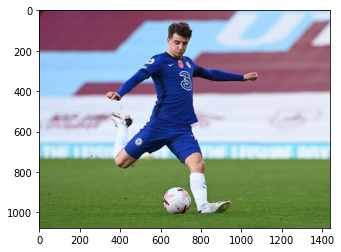

Predicted: a soccer player is kicking a soccer ball


In [21]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(path1)
imgplot = plt.imshow(img)
plt.show()

x = generate_predictions(topic_embedding1, image_embedding1, model, tokenizer.word_index, tokenizer.index_word, 30)
print("Predicted:",x)

Populating the interactive namespace from numpy and matplotlib


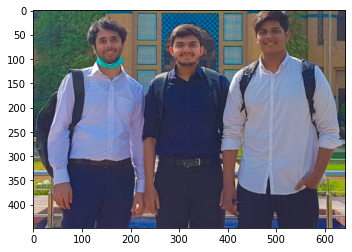

Predicted: a group of men standing next to each other


In [22]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(path2)
imgplot = plt.imshow(img)
plt.show()

x = generate_predictions(topic_embedding2, image_embedding2, model, tokenizer.word_index, tokenizer.index_word, 30)
print("Predicted:",x)